In [1]:
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp
import jax
import torch
from tqdm.notebook import tqdm, trange
from flax import struct
from scipy.stats import gaussian_kde
import ot
import typing as tp
from torch.distributions import Categorical
from torch.distributions import MultivariateNormal as MNormal

In [2]:
# https://github.com/svsamsonov/ex2mcmc_new/blob/master/ex2mcmc/metrics/total_variation.py
# https://github.com/svsamsonov/Practical_task/blob/main/metrics.py

def ESS(A):
    A = A * (A > 0.05)
    ess = 1.0 / (1.0 + 2 * np.sum(A[1:, ...], axis=0))
    return ess

def autocovariance(X, tau=0):
    dT = X.shape[0]
    s = 0.0
    dN = 1
    if tau > 0:
        x1 = X[:-tau, ...]
    else:
        x1 = X
    x2 = X[tau:, ...]
    s = np.sum(x1 * x2, axis=0) / dN

    return s / (dT - tau)

def acl_spectrum(X, n=150, scale=None):
    scale = (
        np.array(scale)
        if scale is not None
        else np.sqrt(autocovariance(X, tau=0))
    )
    return np.stack(
        [
            autocovariance(X / (scale[None, ...] + 1e-7), tau=t)
            for t in range(n - 1)
        ],
        axis=0,
    )

class MeanTracker:
    def __init__(self):
        self.values = []

    def update(self, value: float) -> None:
        self.values.append(value)

    def __len__(self):
        return len(self.values)

    def mean(self) -> float:
        return jnp.mean(jnp.array(self.values))

    def std(self) -> float:
        return jnp.std(jnp.array(self.values), ddof=1)

    def std_of_mean(self) -> float:
        return jnp.std(jnp.array(self.values)) / jnp.sqrt(len(self))

    def last(self) -> float:
        return self.values[-1]

@struct.dataclass
class Projector:
    x0: jnp.ndarray
    v: jnp.ndarray

    def project(self, xs: jnp.ndarray) -> jnp.ndarray:
        return (xs - self.x0[None]) @ self.v

def create_random_projection(key: jnp.ndarray, xs: jnp.ndarray) -> Projector:
    x0 = jnp.mean(xs, 0)
    v = jax.random.normal(key, [len(x0)])
    v = v / jnp.linalg.norm(v)

    return Projector(x0, v)

def average_total_variation(
    key: jnp.ndarray,
    true: jnp.ndarray,
    other: jnp.ndarray,
    n_samples: int,
    n_steps: int,
) -> MeanTracker:
    tracker = MeanTracker()
    keys = jax.random.split(key, n_steps)

    for b in range(other.shape[1]):
        for i in trange(n_steps, leave=False):
            tracker.update(total_variation(keys[i], true, other[:, b], n_samples))
    return tracker

def total_variation(
    key: jnp.ndarray,
    xs_true: jnp.ndarray,
    xs_pred: jnp.ndarray,
    n_samples: int,
):
    proj = create_random_projection(key, xs_true)
    return total_variation_1d(
        proj.project(xs_true),
        proj.project(xs_pred),
        n_samples,
    )


def total_variation_1d(xs_true, xs_pred, n_samples):
    true_density = gaussian_kde(xs_true)
    pred_density = gaussian_kde(xs_pred)

    x_min = min(xs_true.min(), xs_pred.min())
    x_max = max(xs_true.max(), xs_pred.max())

    points = np.linspace(x_min, x_max, n_samples)

    return (
        0.5
        * np.abs(true_density(points) - pred_density(points)).mean()
        * (x_max - x_min)
    )


def compute_metrics(
    xs_true,
    xs_pred,
    name=None,
    n_samples=1000,
    scale=1.0,
    trunc_chain_len=None,
    ess_rar=1,
):
    metrics = dict()
    key = jax.random.PRNGKey(0)
    n_steps = 50

    ess = ESS(
        acl_spectrum(
            xs_pred[::ess_rar] - xs_pred[::ess_rar].mean(0)[None, ...],
        ),
    ).mean()
    metrics["ess"] = ess

    xs_pred = xs_pred[-trunc_chain_len:]
    print(f"Shape of true samples {xs_true.shape} = [n_samples x sample_dim]")
    print(
        f"Shape of generated samples {xs_pred.shape}"
        " = [n_samples x n_independent_runs x sample_dim]"
        )

    tracker = average_total_variation(
        key,
        xs_true,
        xs_pred,
        n_steps=n_steps,
        n_samples=n_samples,
    )

    metrics["tv_mean"] = tracker.mean()
    metrics["tv_conf_sigma"] = tracker.std_of_mean()

    mean = tracker.mean()
    std = tracker.std()

    metrics["emd"] = 0
    for b in range(xs_pred.shape[1]):
        M = ot.dist(xs_true / scale, xs_pred[:, b,:] / scale)
        emd = ot.lp.emd2([], [], M, numItermax = 1e6)
        metrics["emd"] += emd / xs_pred.shape[1]

    if name is not None:
        print(f"===={name}====")
    print(
        f"TV distance. Mean: {mean:.3f}, Std: {std:.3f}. \nESS: {ess:.3f} \nEMD: {emd:.3f}",
    )

    return metrics

def ema(series, n: int) -> list:

    series = np.array(series)
    ema = []
    j = 1

    sma = sum(series[:n]) / n
    multiplier = 2 / float(1 + n)
    ema.append(sma)

    ema.append(( (series[n] - sma) * multiplier) + sma)

    for i in series[n+1:]:
        tmp = ( (i - ema[j]) * multiplier) + ema[j]
        j = j + 1
        ema.append(tmp)

    return ema

def compute_metric_over_runs(
    target: tp.Callable,
    sampler: object,
    target_args: dict,
    sampler_args: dict,
    name: str,
    n_runs: int = 50,
    n_samples: int = 1000,
    dim: int = 10
):
    target_dist = target(**target_args)
    all_runs = []
    for _ in tqdm(range(n_runs)):
        one_run_chain, acc_rate = sampler(
            start=torch.rand(1, dim),
            target=target_dist,
            **sampler_args
        )
        all_runs.append(one_run_chain)


    true_samples = target_dist.sample(dim=dim, n_samples=n_samples)
    generated_sample = torch.cat(all_runs, dim=1).detach().numpy()

    trunc_chain_len = 1000
    metrics = compute_metrics(
                        true_samples,
                        generated_sample,
                        name=name,
                        trunc_chain_len=trunc_chain_len,
                        ess_rar=1,
    )

## Algorithms

In [35]:
device = torch.device('cuda')

### ISIR

In [32]:
def isir_sampler(initial: torch.FloatTensor,
                 target_dist,
                 proposal_dist,
                 num_samples: int,
                 burn_in: int,
                 *,
                 num_particles: int,
                 verbose: bool = False):
    """
    Iterated Sampling Importance Resampling (ISIR) algorithm.

    Parameters:
        initial: Tensor of starting positions with shape [n_chains, dim].
        target_dist: Target distribution object with a method 'log_prob'.
        proposal_dist: Proposal distribution object with methods 'log_prob' and 'sample'.
        num_samples: Number of samples to retain from each chain after burn-in.
        burn_in: Number of initial iterations to discard.
        num_particles: Total number of particles to consider (including the current state).
        verbose: If True, display a progress bar during sampling.

    Returns:
        A tuple containing:
          - A tensor with shape [num_samples, n_chains, dim] holding the final chains.
          - A list with the acceptance rate at each iteration.
    """
    chains_record = []
    acceptance_rates = []

    # Set up the initial state.
    current = initial.clone()
    current_log_target = target_dist.log_prob(current)
    current_log_proposal = proposal_dist.log_prob(current)

    # Choose the iteration function (with progress bar if requested).
    iter_func = trange if verbose else range

    for iteration in iter_func(num_samples + burn_in):
        # Draw additional candidate particles.
        candidates = proposal_dist.sample((current.shape[0], num_particles - 1))
        # Compute log probabilities for both target and proposal.
        candidate_log_proposal = proposal_dist.log_prob(candidates)
        candidate_log_target = target_dist.log_prob(candidates)
        
        # Concatenate the current state with the new candidates.
        all_particles = torch.cat([current[:, None, :], candidates], dim=1)
        all_log_proposal = torch.cat([current_log_proposal[:, None], candidate_log_proposal], dim=1)
        all_log_target = torch.cat([current_log_target[:, None], candidate_log_target], dim=1)

        # Calculate importance weights.
        weights = all_log_target - all_log_proposal
        
        # Sample a new state using the categorical distribution defined by the weights.
        chosen_idx = Categorical(logits=weights).sample()
        index = torch.arange(current.shape[0])
        
        current = all_particles[index, chosen_idx]
        current_log_target = all_log_target[index, chosen_idx]
        current_log_proposal = all_log_proposal[index, chosen_idx]

        # Compute the acceptance rate for this iteration.
        acceptance_rates.append((chosen_idx != 0).float().mean().item())

        # After the burn-in period, store the state.
        if iteration >= burn_in:
            chains_record.append(current.detach().clone())

    final_chains = torch.stack(chains_record, dim=0)
    return final_chains, acceptance_rates


### Adaptive ISIR

In [ ]:
# From Seminar 9, 10

def MALA_step(start: torch.FloatTensor,
        target,
        *,
        step_size: float,
        verbose: bool=False):
    std_normal = MNormal(torch.zeros(start.shape[-1]), torch.eye(start.shape[-1]))

    x = start.clone()
    x.requires_grad_(True)
    x.grad = None
    logp_x = target.log_prob(x)
    grad_x = torch.autograd.grad(logp_x.sum(), x)[0]

    range_ = trange if verbose else range

    noise =  torch.randn_like(x)
    y = x + step_size * grad_x + noise * (2 * step_size) ** .5

    logp_y = target.log_prob(y)
    grad_y = torch.autograd.grad(logp_y.sum(), y)[0]

    log_qyx = std_normal.log_prob(noise)
    log_qxy = std_normal.log_prob((x - y - step_size * grad_y) / (2 * step_size) ** .5)

    accept_prob = torch.clamp((logp_y + log_qxy - logp_x - log_qyx).exp(), max=1)
    mask = torch.rand_like(accept_prob) < accept_prob

    with torch.no_grad():
        x[mask, :] = y[mask, :]
        logp_x[mask] = logp_y[mask]
        grad_x[mask] = grad_y[mask]

    return x.detach().data.clone()

In [ ]:
# From Seminar 10, https://github.com/VincentStimper/normalizing-flows/tree/master/normflows and https://arxiv.org/pdf/2105.12603.pdf

def AISIR(NF, target, proposal, n_chains, optimizer, mala_step_size, langevin_steps, n_samples, burn_in, n_particles=100, verbose=False):

    NF.train()
    start = proposal.sample((n_chains,)).detach().cpu().squeeze()
    losses = []
    chains = []
    range_ = trange if verbose else range
    for idx in range_(n_samples + burn_in):
        optimizer.zero_grad()
        if idx % langevin_steps == 0:
            logp_x = target.log_prob(start)
            temp, log_det = NF.inverse_and_log_det(start.to(device))
            logq_x = proposal.log_prob(temp) + torch.abs(log_det)
            particles = proposal.sample((start.shape[0], n_particles - 1)).squeeze()
            particles_flat = torch.flatten(particles, end_dim=1)
            particles_flat = NF(particles_flat)

            temp, log_det = NF.inverse_and_log_det(particles_flat.to(device))
            ll_particles = proposal.log_prob(temp) + torch.abs(log_det)

            logqs = torch.cat([logq_x[:, None], ll_particles.reshape(particles.shape[:-1])], 1)
            logps = torch.cat([logp_x[:, None], target.log_prob(particles_flat).reshape(particles.shape[:-1])], 1)
            particles = torch.cat([start[:, None, :], particles_flat.reshape(particles.shape)], 1)

            log_weights = logps - logqs
            indices = Categorical(logits=log_weights).sample()

            start = particles[np.arange(start.shape[0]), indices]
        else:
            start = MALA_step(start, target, step_size = mala_step_size)

        if idx >= burn_in:
            chains.append(start.detach().data.clone())

        loss = NF.forward_kld(start.to(device))

        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
            losses.append(loss.detach().cpu())

    chains = torch.stack(chains, 0)
    NF.eval()
    return chains, NF

### HMC

In [33]:
import torch
from pyro.infer import HMC as pyro_hmc
from pyro.infer import MCMC
from pyro.infer import NUTS as pyro_nuts

# From Seminar 12

def HMC(
    start,
    target,
    n_samples: int,
    burn_in: int,
    *,
    step_size: float,
    num_leapfrog_steps: float = 1,
    verbose: bool = False,
) -> torch.FloatTensor:
    x = start.clone()
    x.requires_grad_(False)

    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = pyro_hmc(
        potential_fn=energy,
        step_size=step_size,
        num_steps=num_leapfrog_steps,
        full_mass=False,
    )

    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape)

    return samples_true, _

### MALA

In [34]:
from torch.distributions import MultivariateNormal as MNormal


# From Seminar 10

def MALA(start: torch.FloatTensor,
        target,
        n_samples: int,
        burn_in: int,
        *,
        step_size: float,
        verbose: bool=False) -> tuple[torch.FloatTensor, list]:
    std_normal = MNormal(torch.zeros(start.shape[-1], device=start.device), torch.eye(start.shape[-1], device=start.device))
    chains = []
    acceptance_rate = []

    x = start.clone()
    x.requires_grad_(True)
    x.grad = None

    logp_x = target.log_prob(x)
    grad_x = torch.autograd.grad(logp_x.sum(), x)[0]

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        noise =  torch.randn_like(x)
        y = x + step_size * grad_x + noise * (2 * step_size) ** .5
        logp_y = target.log_prob(y)
        grad_y = torch.autograd.grad(logp_y.sum(), y)[0]

        log_qyx = std_normal.log_prob(noise)
        log_qxy = std_normal.log_prob((x - y - step_size * grad_y) / (2 * step_size) ** .5)

        accept_prob = torch.clamp((logp_y + log_qxy - logp_x - log_qyx).exp(), max=1)
        mask = torch.rand_like(accept_prob) < accept_prob

        with torch.no_grad():
            x[mask, :] = y[mask, :]
            logp_x[mask] = logp_y[mask]
            grad_x[mask] = grad_y[mask]

        acceptance_rate.append(mask.float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.cpu().clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate

### ULA

In [36]:
# From Seminar 10

def ULA(start: torch.FloatTensor,
        target,
        n_samples: int,
        burn_in: int,
        *,
        step_size: float,
        verbose: bool=False) -> torch.FloatTensor:
    chains = []
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        log_prob = target.log_prob(x)
        grad = torch.autograd.grad(log_prob.sum(), x)[0]
        x = x + step_size * grad + (2 * step_size) ** .5 * torch.randn_like(x)

        if step_id >= burn_in:
            chains.append(x.detach().data.clone())
    chains = torch.stack(chains, 0)
    return chains, _

In [ ]:

def decision(probability):
    return torch.rand(probability.shape[0]) < probability

def plot_results(samples, distr, log_prob_reshape=None, n_pts=100, scale_border=1.0, title=None):
    """
    Plot the probability density of a distribution over a 2D grid and overlay the samples with a custom style.

    Parameters:
        samples (torch.Tensor): Samples drawn from the distribution.
        distr: A distribution object with a `log_prob` method.
        log_prob_reshape (callable, optional): Function to reshape log probabilities. Defaults to None.
        n_pts (int, optional): Number of points in each grid dimension. Defaults to 100.
        scale_border (float, optional): Scaling factor for grid limits based on sample norms. Defaults to 1.0.
        title (str, optional): Title for the plot. Defaults to None.
    """
    # Compute the maximum norm of the samples to define the grid's border.
    border = torch.linalg.norm(samples, dim=1).max().item()

    # Create a grid spanning from -scale_border*border to scale_border*border.
    xs = np.linspace(-scale_border * border, scale_border * border, n_pts)
    ys = np.linspace(-scale_border * border, scale_border * border, n_pts)
    X, Y = np.meshgrid(xs, ys)

    # Stack grid coordinates to create a tensor of shape (n_pts, n_pts, 2)
    grid_points = torch.tensor(np.stack([X, Y], axis=-1), dtype=torch.float)

    # Compute log probabilities over the grid.
    if log_prob_reshape is None:
        log_probs = distr.log_prob(grid_points)
    else:
        log_probs = log_prob_reshape(grid_points)

    # Set a custom style for the plot.
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create a filled contour plot of the probability density.
    contour = ax.contourf(X, Y, log_probs.exp(), levels=20, cmap='inferno', alpha=0.8)
    # Add a colorbar with a label.
    cbar = fig.colorbar(contour, ax=ax, label='Probability Density')

    # Scatter plot the original samples.
    # If the log probabilities of samples are torch tensors, convert them to numpy.
    sample_colors = distr.log_prob(samples)
    if hasattr(sample_colors, 'detach'):
        sample_colors = sample_colors.detach().numpy()
    scatter = ax.scatter(samples[:, 0], samples[:, 1],
                         c=sample_colors, cmap='coolwarm', s=50, edgecolors='k')

    # Set axis labels and title.
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    if title:
        ax.set_title(title, fontsize=16, fontweight='bold')

    plt.show()



In [4]:
#!git clone https://github.com/svsamsonov/Practical_task
import sys
sys.path.append('Practical_task') if 'Practical_task' not in sys.path else None

# Task 1

In [5]:
# https://github.com/svsamsonov/Practical_task/blob/main/distributions.py
from distributions import Distribution
class Cauchy(Distribution):
    def __init__(self, **kwargs):

        super().__init__(**kwargs)
        self.loc = kwargs.get("loc")
        self.scale = kwargs.get("scale")
        self.dim = len(self.loc)
        self.distr = torch.distributions.Cauchy(self.loc, self.scale)

    def log_prob(self, z, x=None):
        log_target = self.distr.log_prob(z).mean(-1)#.sum(-1)
        return log_target

    def sample(self, n=(1,)):
        return self.distr.sample(n).squeeze()


class GaussianMixture:
    def __init__(self, dim, sigma, loc):
        self.g0 = MNormal(loc, sigma ** 2 * torch.eye(dim))
        self.g1 = MNormal(-loc, sigma ** 2 * torch.eye(dim))
        self.prob = 0.5
        self.dim = dim

    def sample(self, shape=(2,)):
        idx = decision(self.prob * torch.ones(shape[0]))
        samples = torch.zeros((shape[0], self.dim))
        samples[idx] = self.g0.sample(shape).squeeze()[idx]
        samples[~idx] = self.g1.sample(shape).squeeze()[~idx]
        return samples

    def log_prob(self, x):
        return (0.5 * self.g0.log_prob(x).exp() + 0.5 * self.g1.log_prob(x).exp() + 1e-8).log()

  0%|          | 0/1100 [00:00<?, ?it/s]

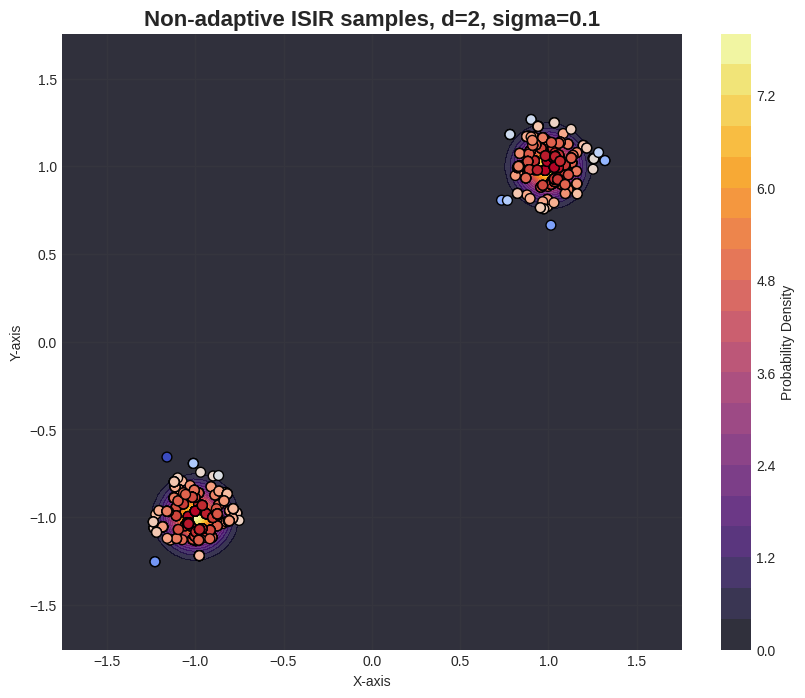

Shape of true samples (1000, 2) = [n_samples x sample_dim]
Shape of generated samples (1000, 50, 2) = [n_samples x n_independent_runs x sample_dim]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

====I-SIR |d=2|s=0.1====
TV distance. Mean: 0.058, Std: 0.068. 
ESS: 0.065 
EMD: 0.163


  0%|          | 0/1100 [00:00<?, ?it/s]

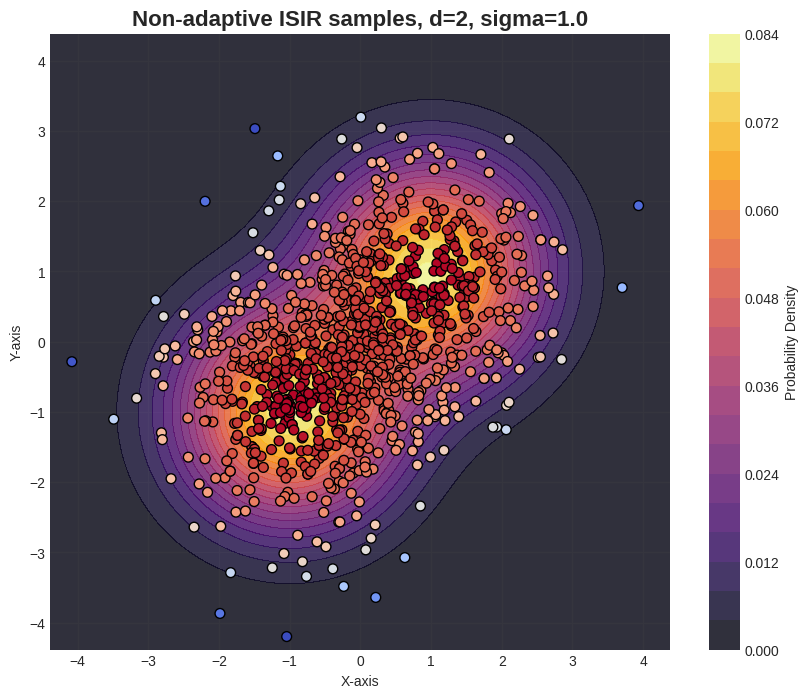

Shape of true samples (1000, 2) = [n_samples x sample_dim]
Shape of generated samples (1000, 50, 2) = [n_samples x n_independent_runs x sample_dim]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

====I-SIR |d=2|s=1.0====
TV distance. Mean: 0.148, Std: 0.344. 
ESS: 0.479 
EMD: 0.167


  0%|          | 0/1100 [00:00<?, ?it/s]

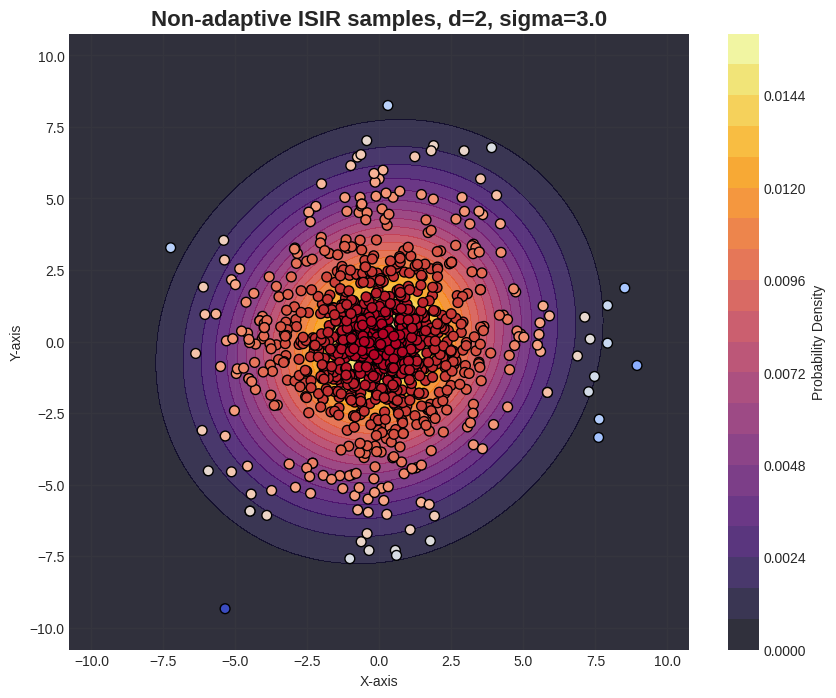

Shape of true samples (1000, 2) = [n_samples x sample_dim]
Shape of generated samples (1000, 50, 2) = [n_samples x n_independent_runs x sample_dim]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

====I-SIR |d=2|s=3.0====
TV distance. Mean: 0.216, Std: 0.016. 
ESS: 0.483 
EMD: 2.726


  0%|          | 0/1100 [00:00<?, ?it/s]

Shape of true samples (1000, 10) = [n_samples x sample_dim]
Shape of generated samples (1000, 50, 10) = [n_samples x n_independent_runs x sample_dim]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

====I-SIR |d=10|s=0.1====
TV distance. Mean: 1.285, Std: 15.844. 
ESS: 0.745 
EMD: 825530.964


  0%|          | 0/1100 [00:00<?, ?it/s]

Shape of true samples (1000, 10) = [n_samples x sample_dim]
Shape of generated samples (1000, 50, 10) = [n_samples x n_independent_runs x sample_dim]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

====I-SIR |d=10|s=1.0====
TV distance. Mean: 0.950, Std: 1.426. 
ESS: 0.765 
EMD: 2094397.602


  0%|          | 0/1100 [00:00<?, ?it/s]

Shape of true samples (1000, 10) = [n_samples x sample_dim]
Shape of generated samples (1000, 50, 10) = [n_samples x n_independent_runs x sample_dim]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

====I-SIR |d=10|s=3.0====
TV distance. Mean: 1.028, Std: 2.564. 
ESS: 0.741 
EMD: 237227788.116


  0%|          | 0/1100 [00:00<?, ?it/s]

Shape of true samples (1000, 50) = [n_samples x sample_dim]
Shape of generated samples (1000, 50, 50) = [n_samples x n_independent_runs x sample_dim]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

====I-SIR |d=50|s=0.1====
TV distance. Mean: 1.016, Std: 1.929. 
ESS: 0.758 
EMD: 286693966.541


  0%|          | 0/1100 [00:00<?, ?it/s]

Shape of true samples (1000, 50) = [n_samples x sample_dim]
Shape of generated samples (1000, 50, 50) = [n_samples x n_independent_runs x sample_dim]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

====I-SIR |d=50|s=1.0====
TV distance. Mean: 0.974, Std: 1.890. 
ESS: 0.757 
EMD: 4213279.280


  0%|          | 0/1100 [00:00<?, ?it/s]

Shape of true samples (1000, 50) = [n_samples x sample_dim]
Shape of generated samples (1000, 50, 50) = [n_samples x n_independent_runs x sample_dim]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

====I-SIR |d=50|s=3.0====
TV distance. Mean: 0.886, Std: 0.422. 
ESS: 0.756 
EMD: 1443819377.580


  0%|          | 0/1100 [00:00<?, ?it/s]

Shape of true samples (1000, 100) = [n_samples x sample_dim]
Shape of generated samples (1000, 50, 100) = [n_samples x n_independent_runs x sample_dim]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

====I-SIR |d=100|s=0.1====
TV distance. Mean: 0.934, Std: 1.945. 
ESS: 0.754 
EMD: 237112795.577


  0%|          | 0/1100 [00:00<?, ?it/s]

Shape of true samples (1000, 100) = [n_samples x sample_dim]
Shape of generated samples (1000, 50, 100) = [n_samples x n_independent_runs x sample_dim]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

====I-SIR |d=100|s=1.0====
TV distance. Mean: 0.968, Std: 0.844. 
ESS: 0.752 
EMD: 91069129.320


  0%|          | 0/1100 [00:00<?, ?it/s]

Shape of true samples (1000, 100) = [n_samples x sample_dim]
Shape of generated samples (1000, 50, 100) = [n_samples x n_independent_runs x sample_dim]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

====I-SIR |d=100|s=3.0====
TV distance. Mean: 0.932, Std: 0.886. 
ESS: 0.754 
EMD: 7692466.117


In [9]:


dimensions = [2, 10, 50, 100]
sigma_values = [0.1, 1.0, 3.0]

for current_dim in dimensions:
    for current_sigma in sigma_values:
        # Initialize the target distribution as a Gaussian mixture,
        # using a mean vector of ones with the current dimension.
        target_dist = GaussianMixture(loc=torch.ones(1, current_dim),
                                      sigma=current_sigma,
                                      dim=current_dim)

        # Set up the proposal distribution with a Cauchy distribution,
        # having a zero vector as the location.
        proposal_dist = Cauchy(loc=torch.zeros(1, current_dim),
                               scale=torch.ones(1, current_dim),
                               dim=current_dim,
                               device=device)

        # Define simulation parameters.
        num_chains = 50
        num_samples = 10**3
        burn_in_period = 10**2

        # Draw initial samples for all chains from the proposal.
        initial_samples = proposal_dist.sample((num_chains,)).detach().cpu()

        # Run the Iterated Sampling Importance Resampling (ISIR) algorithm.
        sampled_chains, acceptance_rates = isir_sampler(initial_samples, target_dist, proposal_dist,
                                                num_samples, burn_in_period,
                                                num_particles=50, verbose=True)

        # For a two-dimensional case, visualize the samples from the first chain.
        if current_dim == 2:
            plot_results(sampled_chains[:, 0, :],
                         target_dist,
                         title=f'Non-adaptive ISIR samples, d={current_dim}, sigma={current_sigma}')

        # Draw ground-truth samples from the target distribution for metric evaluation.
        true_samples = target_dist.sample((num_samples,)).squeeze()

        # Compare the ISIR-generated chains with the true target samples.
        compute_metrics(true_samples.numpy(),
                        sampled_chains.numpy(),
                        name=f'I-SIR |d={current_dim}|s={current_sigma}',
                        n_samples=num_samples,
                        trunc_chain_len=num_samples,
                        ess_rar=1)


## Task 2

In [30]:
class Banana(Distribution):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.device = kwargs.get("device", "cpu")
        self.nu = kwargs.get("nu", 1.0)
        self.dim = kwargs.get("dim", 32)
        self.xlim = [-1, 5]
        self.ylim = [-2, 2]
        self.scale_2d_log_prob = 2.0
        # assert self.dim % 2 == 0, 'Dimension should be divisible by 2'

    def log_prob(self, z):
        even = np.arange(0, z.shape[-1], 2)
        odd = np.arange(1, z.shape[-1], 2)

        ll = (-(z[..., odd] - z[..., even]**2)**2 / self.nu - (z[..., even] - 1)**2).sum(-1)
        return ll

    def sample(self, shape=(10,), dim=None, n_samples=None):
        
        true_samples = np.random.randn(shape[0], self.dim) * np.sqrt(1 / 2)
        for i in range(self.dim):
            if i % 2 == 0:
                true_samples[:,i] = (1 + true_samples[:,i])
            else:
                true_samples[:,i] = np.sqrt(self.nu) * true_samples[:,i] + true_samples[:, i-1]**2
        return true_samples

  0%|          | 0/1100 [00:00<?, ?it/s]

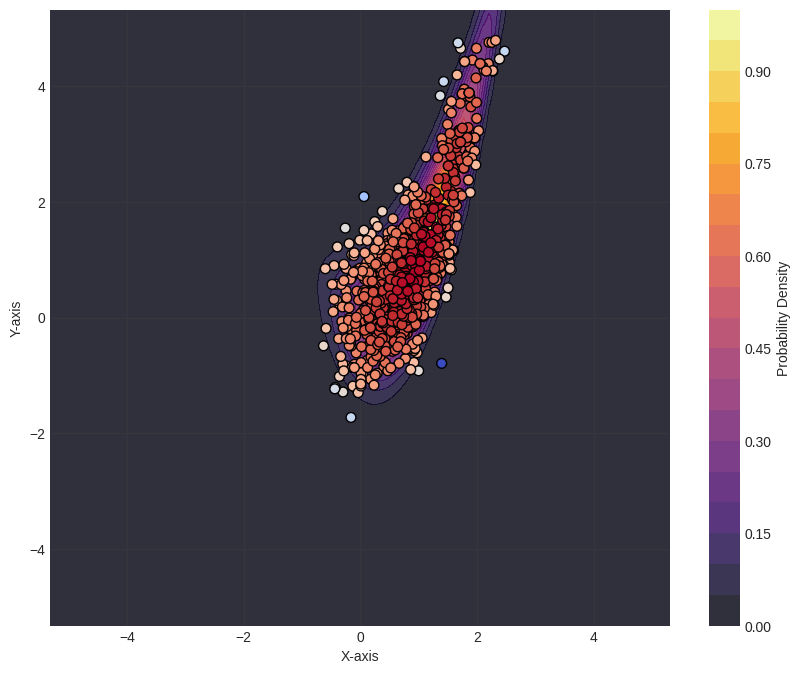

Shape of true samples (1000, 2) = [n_samples x sample_dim]
Shape of generated samples (1000, 50, 2) = [n_samples x n_independent_runs x sample_dim]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

====MALA |nu=1.0====
TV distance. Mean: 0.189, Std: 0.084. 
ESS: 0.013 
EMD: 0.446


{'ess': np.float32(0.012630578),
 'tv_mean': Array(0.18872075, dtype=float32),
 'tv_conf_sigma': Array(0.00168414, dtype=float32),
 'emd': 1.2576157974073103}

In [ ]:
d = 2
nu = 1.0
target = Banana(dim=d, device=device, nu = nu)

N_CHAINS = 50
N_SAMPLES = 10**3
BURN_IN = 10**2
step_size=3e-2

start_pts = torch.randn((N_CHAINS, d)).detach().cpu()

chains, acceptance_rates_isir = MALA(start_pts, target, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)


log_prob_reshape = lambda Z : target.log_prob(Z.reshape(-1, 2)).reshape(Z.shape[:-1])

true_samples = target.sample((N_SAMPLES,))

plot_results(chains[:, 0, :], target, log_prob_reshape=log_prob_reshape)

compute_metrics(true_samples,
                chains.numpy(),
                name=f'MALA |nu={nu}',
                n_samples=N_SAMPLES,
                trunc_chain_len=N_SAMPLES,
                ess_rar=1)

In [15]:
import normflows as nf

In [18]:
dim = 10
nu = 0.5
HMC_chains, _ = HMC(
    start=torch.rand(1, dim),
    target=Banana(dim=d,
                device=device,
                nu = nu)
,
    n_samples=1000,
    burn_in = 10,
    step_size=0.01,
    num_leapfrog_steps=1,
    verbose=True
)

Sample: 100%|██████████| 1010/1010 [00:00, 2682.72it/s, step size=2.06e-01, acc. prob=0.764]


In [ ]:
compute_metric_over_runs(
    target=Banana,
    sampler=HMC,
    target_args = {"nu": 0.5},
    sampler_args = {
        "n_samples": 1000,
        "burn_in": 10,
        "step_size": 0.01,
        "num_leapfrog_steps": 1,
    },
    name="HMC"
)

  0%|          | 0/50 [00:00<?, ?it/s]

Sample: 100%|██████████| 1010/1010 [00:01, 784.57it/s, step size=2.37e-01, acc. prob=0.694]


Shape of true samples (1000, 10) = [n_samples x sample_dim]
Shape of generated samples (1000, 50, 10) = [n_samples x n_independent_runs x sample_dim]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

====HMC====
TV distance. Mean: 0.404, Std: 0.098. 
ESS: 0.010 
EMD: 31.076


## Task 3

In [ ]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff

--2025-03-08 21:05:52--  https://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 

/home/br0fire/.local/share/uv/python/cpython-3.10.16-linux-x86_64-gnu/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘EEG Eye State.arff’

EEG Eye State.arff      [     <=>            ]   1,62M  1,51MB/s    in 1,1s    

2025-03-08 21:05:54 (1,51 MB/s) - ‘EEG Eye State.arff’ saved [1696428]



In [46]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.io.arff import loadarff
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

# Load the dataset from the ARFF file
raw_data, _ = loadarff('EEG Eye State.arff')
df = pd.DataFrame(raw_data)
df = df.dropna(axis=1)

# Convert byte-string labels to integers
df['eyeDetection'] = df['eyeDetection'].apply(lambda b: int(b.decode('utf-8')))

# Add a bias column and convert labels from {0, 1} to {-1, 1}
df['bias'] = 1
df['eyeDetection'] = df['eyeDetection'] * 2 - 1

# Separate features and target
features = df.drop(columns=['eyeDetection']).values
target = df['eyeDetection'].astype(int).values

# Preprocess features: scale, transform, then scale again
scaler = StandardScaler()
quant_transformer = QuantileTransformer()

features = scaler.fit_transform(features)
features = quant_transformer.fit_transform(features)
features = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target)



In [47]:
class LogRegDistr:
    def __init__(self, X, y, prior):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
        self.prior = prior

    def forward(self, X, theta):
        if len(theta.shape) < 3:
            return torch.sigmoid(X @ theta.T)
        elif len(X.shape) < 2:
            return torch.sigmoid(torch.einsum('i,bji->bj', X, theta))
        else:
            return torch.sigmoid(torch.einsum('ij,bkj->ibk', X, theta))

    def log_prob(self, theta, eps=1e-8):
        pred = self.forward(self.X, theta)
        positive_class = self.y * torch.log(pred + eps).T
        negative_class = (1 - self.y) * torch.log((1 - pred) + eps).T
        cond_log_prob = positive_class.sum() + negative_class.sum()
        return cond_log_prob + self.prior.log_prob(theta)

In [48]:
d = X_train.shape[-1]
sigma = 2.5
proposal = MNormal(loc=torch.zeros(1, d), covariance_matrix=sigma ** 2 * torch.eye(d))
posterior_distr = LogRegDistr(X_train, y_train, prior=proposal)

N_CHAINS = 50
ULA_chain, ULA_acc_rate = ULA(
    start=proposal.sample((N_CHAINS,)).squeeze(),
    target=posterior_distr,
    n_samples=1000,
    burn_in = 100,
    step_size=1e-4,
    verbose=True
)

  0%|          | 0/1100 [00:00<?, ?it/s]

In [53]:
def plot_posterior_predictive(X_test, y_test, posterior_samples, title='plot'):
    plt.figure(figsize=(10, 10))
    predictions = torch.sigmoid(torch.Tensor(X_test) @ posterior_samples[-1].T).mean(dim=1)
    target_test = torch.tensor((y_test + 1) / 2)

    plt.boxplot(predictions.numpy())
    plt.title(title)
    plt.ylabel(r'Posterior $p(y_{test} \mid X_{test}, \theta)$')
    plt.grid(True, axis='y')
    plt.show()

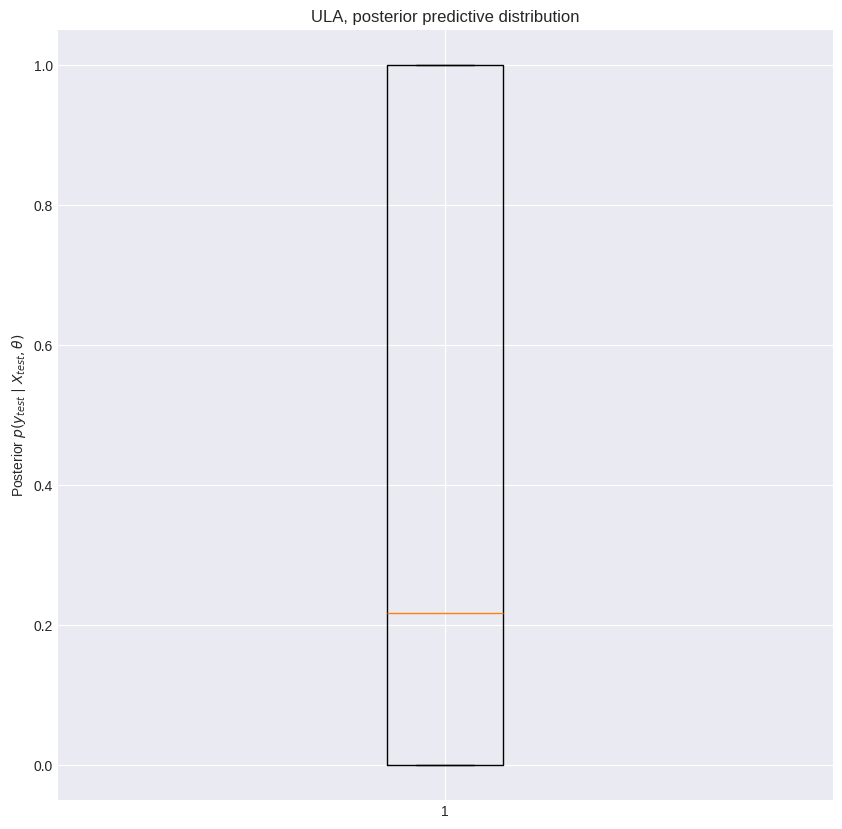

In [54]:
plot_posterior_predictive(X_test, y_test, ULA_chain, title='ULA, posterior predictive distribution')

In [38]:
d = X_train.shape[-1]
sigma = 2.5
proposal = MNormal(loc=torch.zeros(1, d), covariance_matrix=sigma ** 2 * torch.eye(d))
posterior_distr = LogRegDistr(X_train, y_train, prior=proposal)

N_CHAINS = 50

MALA_chain, MALA_acc_rate = MALA(
    start=torch.rand(50, X_train.shape[1]),
    target=posterior_distr,
    n_samples=1000,
    burn_in = 100,
    step_size=1e-4,
    verbose=True
)

  0%|          | 0/1100 [00:00<?, ?it/s]

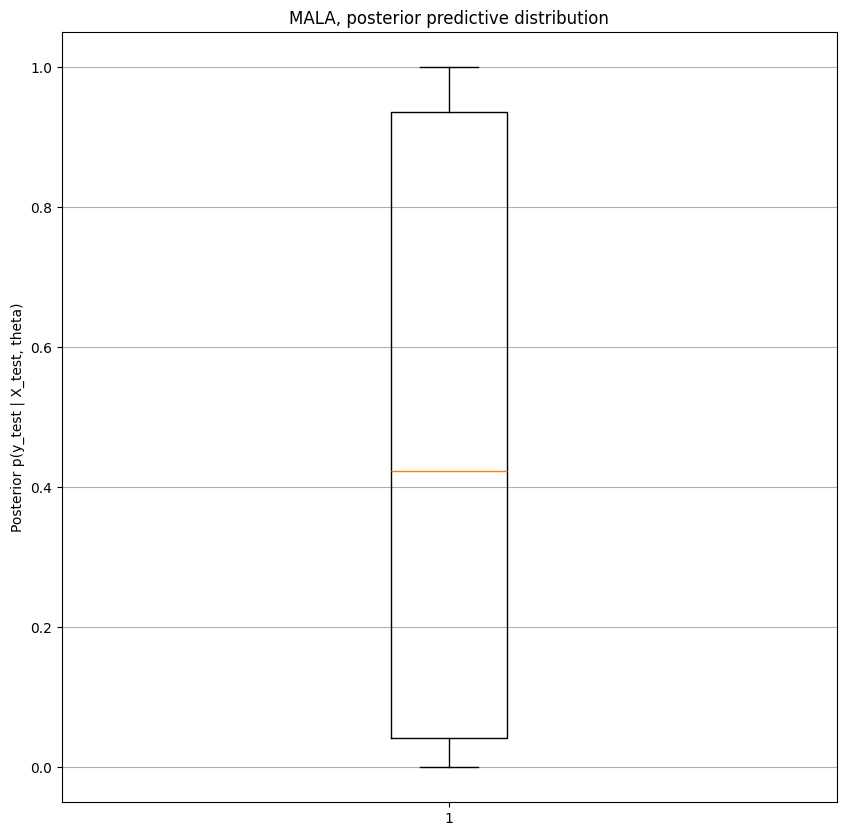

In [ ]:
plot_posterior_predictive(X_test, y_test, MALA_chain, title='MALA, posterior predictive distribution')

In [9]:
class Gaussian:
    def __init__(self, loc, sigma):
        self.dim = loc.shape[0]
        self.distr = MNormal(loc, sigma ** 2 * torch.eye(self.dim))

    def sample(self, shape=(2,)):
        return self.distr.sample(shape).squeeze()

    def log_prob(self, x):
        return self.distr.log_prob(x)

In [41]:
d = X_train.shape[-1]
sigma = 2.5
proposal = Gaussian(loc=torch.zeros(d), sigma=sigma)

posterior_distr = LogRegDistr(X_train, y_train, prior=proposal)
NISIR_chain, NISIR_acceptance_rates = isir_sampler(
    initial=proposal.sample((10,)).detach().cpu(),
    target_dist=posterior_distr,
    proposal_dist=proposal,
    num_samples=1000,
    burn_in=100,
    num_particles=100,
    verbose=True
)

  0%|          | 0/1100 [00:00<?, ?it/s]

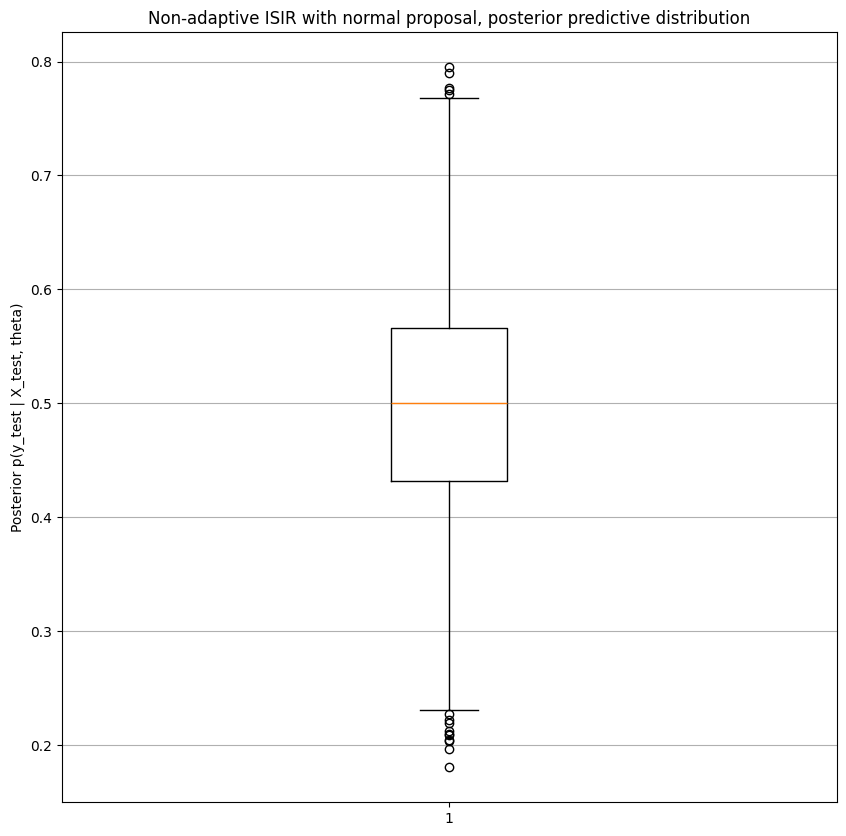

In [ ]:
plot_posterior_predictive(X_test, y_test, MALA_chain, title='Non-adaptive ISIR with normal proposal, posterior predictive distribution')

In [54]:
d = X_train.shape[-1]
sigma = 2.5
proposal = MNormal(loc=torch.zeros(1, d), covariance_matrix=sigma ** 2 * torch.eye(d))

posterior_distr = LogRegDistr(X_train, y_train, prior=proposal)

N_CHAINS = 50
HMC_chain, HMC_acc_rate = HMC(
    start=proposal.sample((N_CHAINS,)),
    target=posterior_distr,
    n_samples=1000,
    burn_in = 100,
    step_size=1e-4,
    num_leapfrog_steps=1,
    verbose=True
)

Sample: 100%|██████████| 1100/1100 [00:05, 217.91it/s, step size=2.13e-03, acc. prob=0.234]


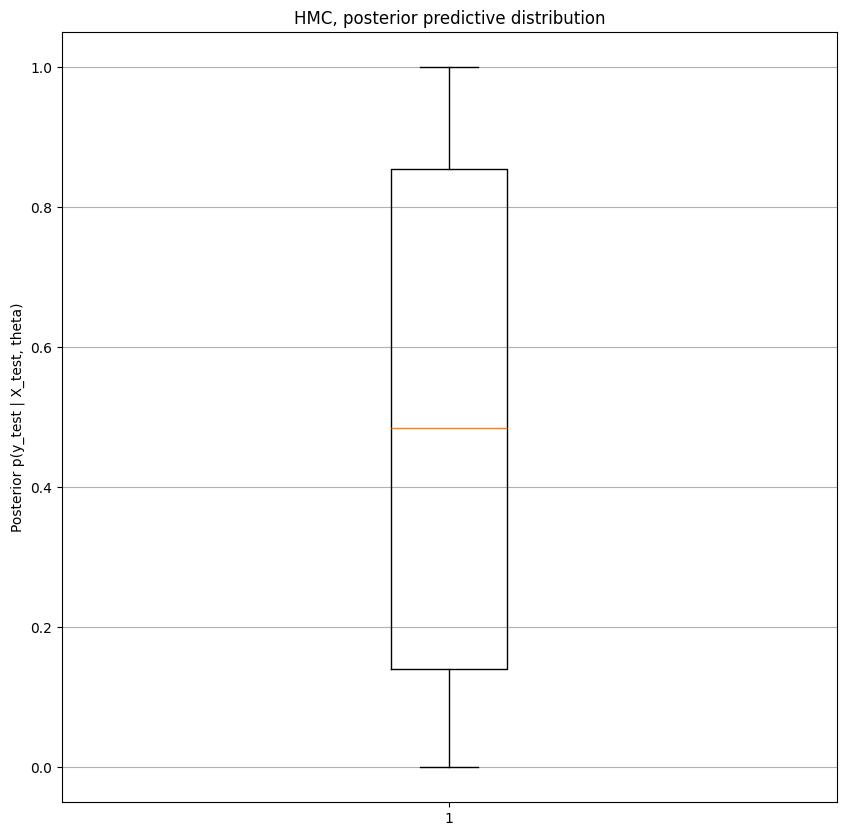

In [ ]:
plot_posterior_predictive(X_test, y_test, HMC_chain, title='HMC, posterior predictive distribution')

In [108]:
# https://github.com/VincentStimper/normalizing-flows/blob/master/examples/augmented_flow.ipynb
import normflows as nf
dim = X_train.shape[1]

K = 32

latent_size = dim
b = torch.Tensor([1] * (latent_size))
flows = []
for i in range(K):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]


q0 = nf.distributions.base.DiagGaussian(dim)


NF = nf.NormalizingFlow(q0=q0, flows=flows)
NF.to(device);

In [ ]:
optimizer = torch.optim.Adam(NF.parameters(), lr=1e-4, weight_decay=1e-6)


proposal = MNormal(loc=torch.zeros(1, dim), covariance_matrix=torch.eye(dim))

posterior_distr = LogRegDistr(X_train, y_train, proposal)

AISIR_chain, NF = AISIR(NF, posterior_distr, proposal, 50, optimizer, 1e-3, 5, 1000, 100, 100)

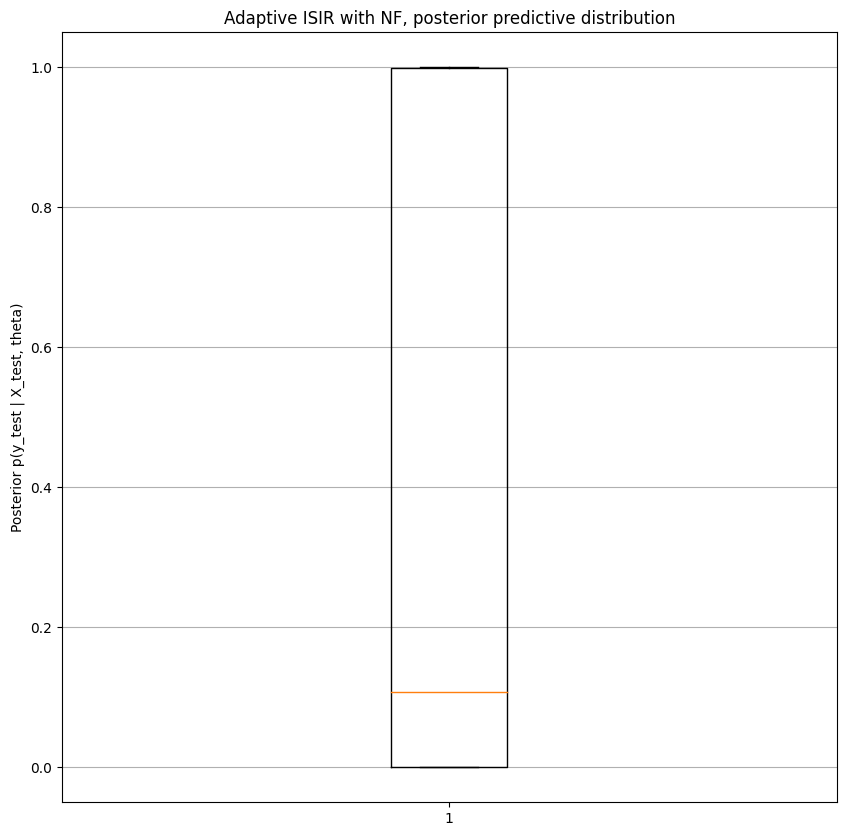

In [ ]:
plot_posterior_predictive(X_test, y_test, AISIR_chain, title='Adaptive ISIR with NF, posterior predictive distribution')